 # Particle Swarm Optimization
 
 In this notebook I would like to show [Particle Swarm Optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization) technique.
 
 I will be using BBOX (Black-Box-Optimization-Benchmarking) function from [COCO](https://coco.gforge.inria.fr/) (COmparing Continuous Optimisers) framework. This frameworks contains 24 parametrized functions (value and position of optimum can be random every evaluation) and the goal of the algorithm is to find minimum in the specified region. Different functions tests different aspects of the algorithm and contains easy to optimize function using simple gradient descent algorithm (function `f01`) as well as asymetric functions (function `f06`) and functions with many local optima (function `f16`). You can find more informations about the individual function in the official [bbobdocfunctions.pdf](http://coco.lri.fr/downloads/download15.02/bbobdocfunctions.pdf) (note that functions in this documents are flip and the task is to maximize them).
 
 I don't want to show only the traditional Particle Swarm Optimization algorithm, but rather evolution of the idea and it improvements. As so, I will start with the simple strategies like gradient descent or random movement and I will incrementally improve this ideas to achieve better results. I will discuss every new idea and compare it to the previous results, so you can see how it change the behavior of the algorithm and how big impact it has on the performance of the algorithm.
 
 Moreover, I implemented different helper methods to execute the strategies and plot the results. In my opinion picture shows more than just numbers. I will try to plot every result that is interesting (that I believe is interesting) so you can really see what is happening inside.

## Code description

Before we dive into the algorithm itself, I want to describe how this repository is implemented so you can try your experiments on your own. First thing you need to have is the COCO framework, that you can download here: [https://github.com/numbbo/coco](https://github.com/numbbo/coco). Unfortunatelly, the framework is written in C and as such needs to be compiled. All the instructions are in the COCO's repository. As far as I know, there is no simple way as `pip install` command.

First of all, I will enable interactive shell. I wanted to show gifs of particles movement over the generations, however, these gifs are quiet a huge files (around 25MB per 100 generations) so I decided not to include them in this notebook. You can enable it on your machine by setting `SHOW_GIFS` variable to `True`. I also export this notebook (including the gifs) to this website: (TODO soon).

In [1]:
%config IPCompleter.greedy=True
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

SHOW_GIFS = False

Now let's import all the libraries. File `functions.py` contains helper functions to import the BBOB functions, `execution.py` than executes the strategies over the functions. Finally `plotting.py` contains helper methods for plotting the results, I will discuss it a little bit later.

In [2]:
import numpy as np
import matplotlib.pylab as plt
import cocoex
import functools
import functions as fn
import execution as exe
import plotting as plot

We may now define our first strategy. Let's start with the simple numeric gradient descent approach. Strategy accepts three parameters: particles, their values and function to optimize.

I implemented gradient computation using helper method in file `execution.py` that computes the gradient of the function by the following formula.
$$
\nabla f(x)_i = \frac{f\left( x_i - gradient\_step \right) - f\left( x_i + gradient\_step \right)}{2 \cdot gradient\_step}
$$

In [3]:
def numeric_gradient_descent(
    particles: np.ndarray, 
    values: np.ndarray, 
    function: cocoex.Problem, 
    gradient_step: float,
    computation_step: float) -> np.ndarray:
    
    gradients = exe.compute_gradient(function, particles, gradient_step)
    return particles - gradients * computation_step

Now it is required to load the functions. It can be done using `fn.get_suite`. You can pass two parameters - how many dimensions should the functions have and which functions to load. The functions can be obtained by iterationg over suite or by calling `get_problem(problem_id)` method. For now I will work with two dimensional function `f01`.

In [4]:
suite = fn.get_suite(dimension=[2], function_indices=[1])
function = suite.get_problem(0)

I will not apply the `numeric_gradient_descent` strategy on that function using `exe.execute` call. You can specify additional parameters - their purpose should be clear from it's name and doc string. The function returns **history** of population and their values.

In [5]:
populations, values = exe.execute(
    function=function,
    algorithm=functools.partial(numeric_gradient_descent, gradient_step=1e-6, computation_step=0.1),
    population_size=10,
    generations=100,
    initialization=np.random.uniform,
    show_progress=True
)

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Now, when I have population and their values, I will plot how the population looked like at the beginning and in the end. The `populations` has shape `(generations, population_size, dimension)`. I implemented `plot.plot_population` function that accepts function to optimize and single population.

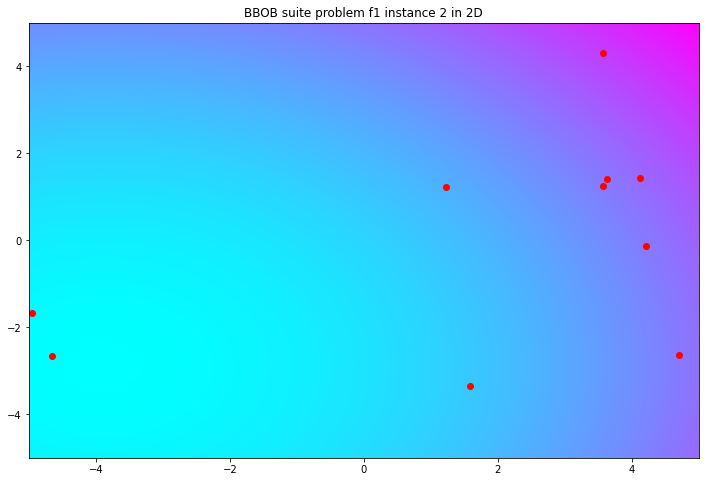

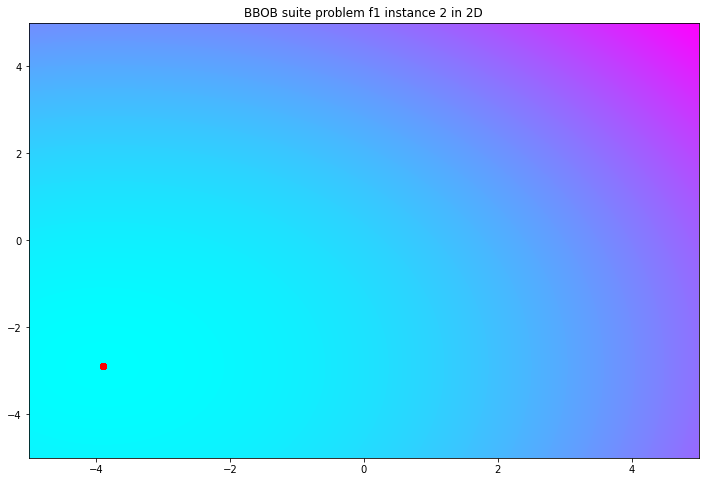

In [6]:
plot.plot_population(function, populations[0])
plot.plot_population(function, populations[-1])

Moreover, if you are interested in movement of individual, you may use `plot.plot_movenemt_of_individual` that accepts function and single member of shape `(generations, dimension)`.

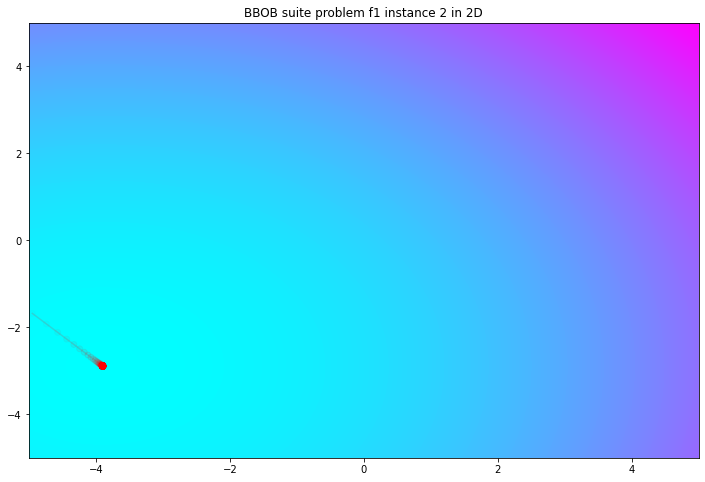

In [7]:
plot.plot_movement_of_individual(function, populations[:,3,:], line_alpha=0.15)

Finally, it is possible to plot movement of the whole population using `plot.animate_movement`. As I already mentioned, generated gifs are around 25MB per 100 generations, so I decided not to include them in this notebook. You can download this notebook and after changing the `SHOW_GIFS` variable to True the gifs would be generated. Alternativelly, you can view following site, where I exported notebook to HTML: (TODO)

In [8]:
if SHOW_GIFS:
    gif = plot.animate_movement(function, populations, figsize=(12,8))
    display.Image(data=gif, format='png')

Before I move on to the plotting of fitness, note that the COCO framework is written in C and as such it needs to release the resources. You should call `free` method on the suite object. I implemented a small wrapper that automatically close the suite after use, however, in that case, you can't use the `function` afterward.

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


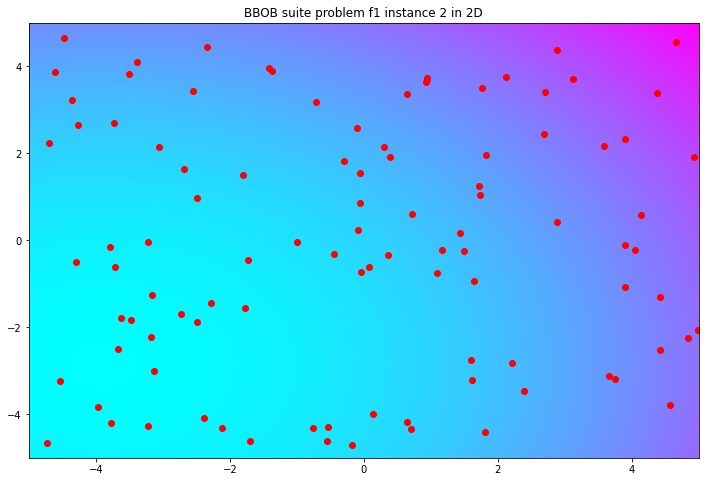

In [9]:
# free the suite
suite.free()

# use wrapper
with fn.get_suite_wrapper(dimension=[2], function_indices=[1]) as suite:
    for function in suite:
        populations, values = exe.execute(
            function,
            functools.partial(numeric_gradient_descent, gradient_step=1e-6, computation_step=0.1),
            show_progress=True
        )
        
        plot.plot_population(function, populations[0])